In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from scipy.ndimage import gaussian_filter1d

1. Loads data from tensorboard for given experiments, writes to dict on format:

``` {experiment_id : {dfs["metric_1"] : df["scenario", "timestep", "metric_value"], ... }, ... } ``` 

2. Plots single-agent training trajectory, color-coded by scenarios. Not used for resultsgen per 03.06

3. Plots a multi-agent version of 2. without scenarios

4. Plots double-agent training trajectories, side by side view for comparison of the two best agents


##### Globals

In [3]:
plt.style.use('ggplot')
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)

current_cycler = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Add two additional new colors to the cycler to fit all 9 scenarios
current_cycler.append('#66C2A5')
current_cycler.append('#FC8D62')

In [4]:
from train3d import scenarios 
scenarios = list(scenarios.keys())
scenarios_plotting_names = ["Line", "Easy", "Easy Random", "Intermediate", "Proficient", "Advanced", "Expert", "Proficient Perturbed", "Expert Perturbed"]

metrics_paths = ["2_terminal_metrics/collision_rate", 
                 "2_terminal_metrics/success_rate",
                 "3_metrics/a_avg_path_progression",
                 "3_metrics/ep_&_a_avg_total_path_deviance",
                 "4_quadcopter_state/ep_&_a_avg_speed"] 
metrics_plotting_names = ["Collision Rate", "Success Rate", "Path Progression", "Average Path Deviance [m]", "Average Speed [m/s]"]
n_metrics = len(metrics_paths)


exp_ids = [32, 10004, 10005, 10007]
agent_names = ["Agent_exp_32", "Agent_exp_10004", "Agent_exp_10005", "Agent_exp_10007"] #TODO FILL    

exp_agents = dict(zip(exp_ids, agent_names))

In [5]:
base_path = "./training_traj_plots/"
os.makedirs(base_path, exist_ok=True)

##### Utils

In [6]:
def centered_subplots(rows,figsize=None):
    
    grid_dim=max(rows)
    grid_shape=(len(rows),2*grid_dim)
    
    if figsize:
        fig = plt.figure(figsize=(figsize))
    else:
        fig = plt.figure(figsize=(2*grid_dim,3*len(rows)))
    
    allaxes=[]
    
    jrow=0
    for row in rows:
        offset=0
        for i in range(row):
            if row<grid_dim:
                offset =grid_dim-row
                
            ax_position=(jrow,2*i+offset)
            ax = plt.subplot2grid(grid_shape, ax_position, fig=fig,colspan=2)
            allaxes.append(ax)
            
        jrow+=1
        
    return fig, allaxes

##### Load data from TensorBoard
And filter faulty timesteps from paused training runs

In [7]:
exp_id_to_dfs = {}

for exp_id in exp_ids:
    dfs = {}

    for metric in metrics_paths:
        df = pd.DataFrame()
        prev_scen_final_timestep = 0
        for scenario in scenarios:
            # Extract tf events from logs for given scenario-metric combo
            log_dir = f"log/LV_VAE_MESH-v0/Experiment {exp_id}/{scenario}/tensorboard/PPO_0/"

            event_accumulator = EventAccumulator(log_dir)
            event_accumulator.Reload()

            events = event_accumulator.Scalars(metric)
            x = [x.step for x in events]
            y = [x.value for x in events]
            
            metric_name = metric.split("/")[-1]
            df_scen = pd.DataFrame({"scenario": scenario, "timestep": x, f"{metric_name}": y})

            # Order by timestep and remove instances with overlapping timesteps, this can happen if training run has been obstructed
            df_scen = df_scen.sort_values("timestep")
            df_scen = df_scen.drop_duplicates(subset="timestep", keep="last")

            # NB timesteps are ordered correctly and no not begin at 0 for each secenario!
            
            # set prev_scen_final_timestep to the final timestep of the current scenario
            if prev_scen_final_timestep > df_scen["timestep"].iloc[0]:
                # Rremove instance
                print(f"Removing overlapping timesteps in scenario {scenario}")
                df_scen = df_scen[df_scen["timestep"] > prev_scen_final_timestep]

            prev_scen_final_timestep = df_scen["timestep"].iloc[-1]
            # Append to the main dataframe
            df = pd.concat([df, df_scen])
        
        dfs[metric_name] = df

        # ensure that timesteps is increasing
        for i in range(1, len(df)):
            if not df["timestep"].iloc[i] > df["timestep"].iloc[i-1]:
                print(f"Error at index {i} in metric: {metric_name}")
                print(df.iloc[i-1:i+1])

    exp_id_to_dfs[exp_id] = dfs
    print("Done loading data for experiment", exp_id)

Removing overlapping timesteps in scenario expert
Removing overlapping timesteps in scenario expert
Removing overlapping timesteps in scenario expert
Removing overlapping timesteps in scenario expert
Removing overlapping timesteps in scenario expert
Done loading data for experiment 32
Done loading data for experiment 10004
Done loading data for experiment 10005
Done loading data for experiment 10007


##### Plot

In [8]:
# Change this to be correct exp id
single_exp_id = 32

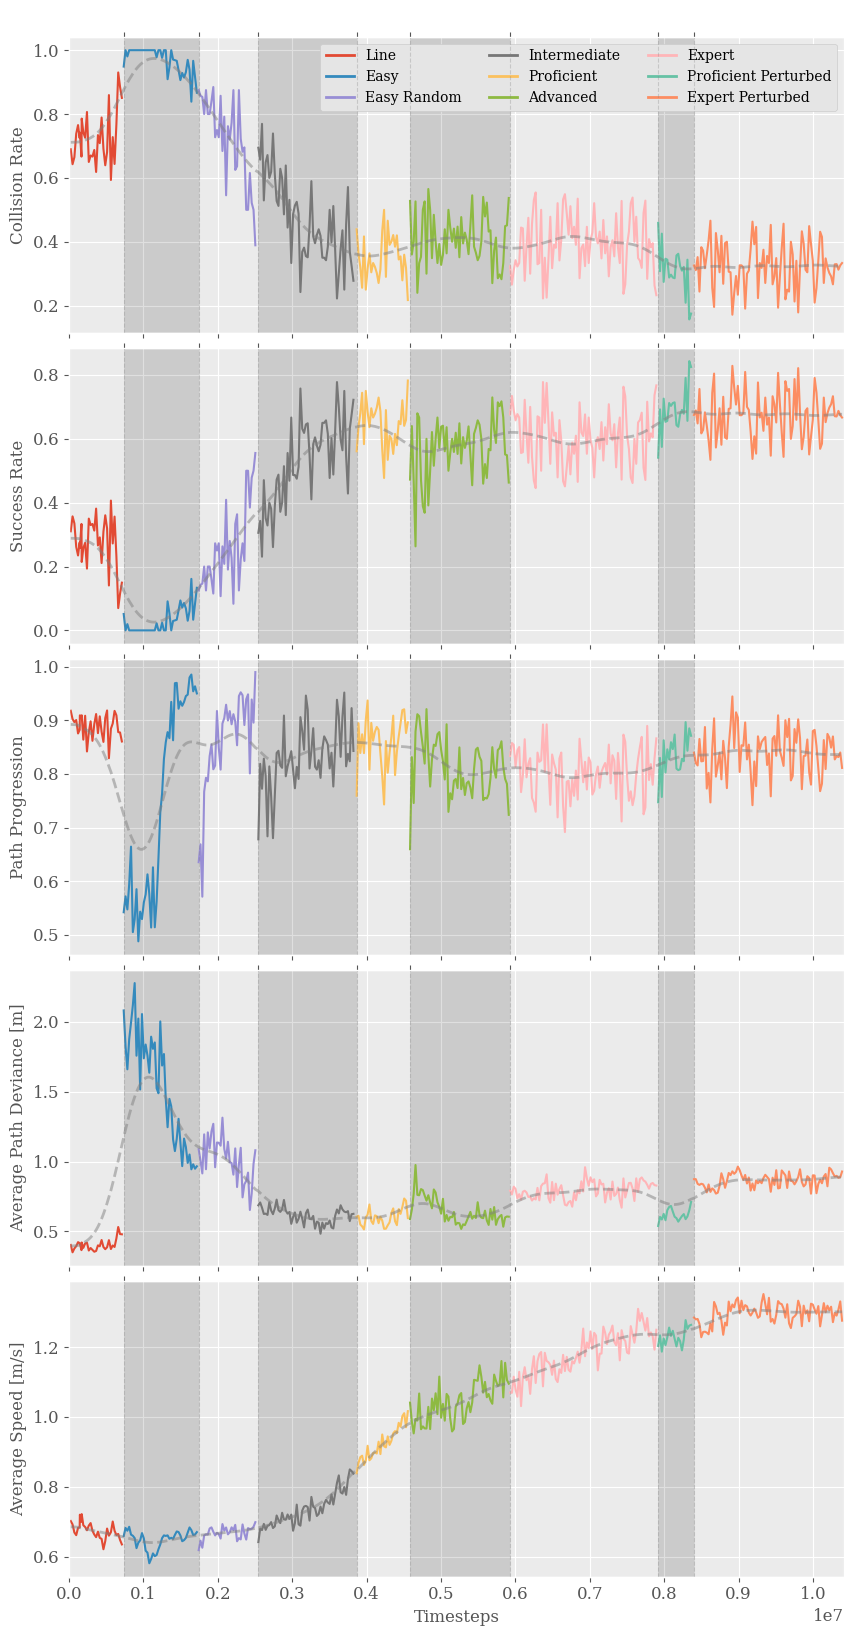

In [9]:
# Retrieve dataframes for the experiment
dfs = exp_id_to_dfs[single_exp_id]

fig, ax = plt.subplots(n_metrics, 1, figsize=(10, 20))

for j, (metric_name, data) in enumerate(dfs.items()):
    lower_bound = min(data[metric_name])
    upper_bound = max(data[metric_name])

    # Group data by scenario and plot each scenario with different color
    for i, scenario in enumerate(scenarios):
        scenario_data = data[data["scenario"] == scenario]
        ax[j].plot(scenario_data["timestep"], scenario_data[metric_name], zorder=5, linewidth=1.5, color=current_cycler[i])
    
    # Plot trend
    values_smooth = gaussian_filter1d(data[metric_name], sigma=10)
    ax[j].plot(data["timestep"], values_smooth, zorder=5, linewidth=2.0, color="gray", alpha=0.5, linestyle="--")

    ylow_fill, yhigh_fill = ax[j].get_ybound()

    for k, scenario in enumerate(scenarios):
        scenario_data = data[data["scenario"] == scenario]
        next_scenario_data = data[data["scenario"] == scenarios[k + 1]] if k + 1 < len(scenarios) else None
        last_index_for_fill = scenario_data["timestep"].iloc[-1] if next_scenario_data is None else next_scenario_data["timestep"].iloc[0]
        color = "white" if k % 2 == 0 else "gray"
        ax[j].fill_between([scenario_data["timestep"].iloc[0], last_index_for_fill], ylow_fill, yhigh_fill, color=color, alpha=0.25, zorder=1)
    
    ax[j].set_xlabel("Timesteps") if j == n_metrics - 1 else ax[j].set_xlabel("")
    if j < n_metrics - 1:
        ax[j].set_xticklabels([])
    ax[j].set_ylabel(metrics_plotting_names[j])
    ax[j].set_xlim(0, data["timestep"].iloc[-1] + data["timestep"].iloc[0])
    ax[j].set_ylim(ylow_fill, yhigh_fill)

    # Add upper axis with scenario names if first plot and only ticks else
    scenario_text_positions_x = []
    upper_ax_ticks = []
    for scenario in scenarios:
        scenario_data = data[data["scenario"] == scenario]
        midpoint = (scenario_data["timestep"].iloc[0] + scenario_data["timestep"].iloc[-1]) // 2
        scenario_text_positions_x.append(midpoint)
        upper_ax_ticks.append(scenario_data["timestep"].iloc[0])

    upper_ax_ticks = upper_ax_ticks[1:]  # Remove first tick
    ax_upper = ax[j].twiny()
    ax_upper.set_xlim(0, data["timestep"].iloc[-1])
    ax_upper.set_xticks(upper_ax_ticks)
    ax_upper.grid(True, which='both', linestyle='--', linewidth=0.8, color='gray', alpha=0.3, zorder=2)
    ax_upper.set_xticklabels([' ' for _ in range(len(scenarios) - 1)])
        
    # Align axes
    ax_upper.set_xbound(ax[j].get_xbound())

    # Increase number of ticks on x-axis to make it more readable
    ax[j].xaxis.set_major_locator(plt.MaxNLocator(11))

    # If first plot add top right legend describing the colors
    legend_elements = [Line2D([0], [0], color=c, lw=2.0, label=label) for c, label in zip(current_cycler[:len(scenarios)], scenarios_plotting_names)]
    if j == 0:
        ax[j].legend(handles=legend_elements, loc="upper right", fontsize=10, framealpha=1.0, fancybox=True, ncol=3, alignment='center')

plt.subplots_adjust(wspace=0, hspace=0.05)
path = f"{base_path}exp_{single_exp_id}_training_trajs.pdf"
plt.savefig(path, bbox_inches='tight')

##### Plot multiagent

In [10]:
# Use all for now, but this can be changed to only use a subset
exp_ids_multi = exp_ids

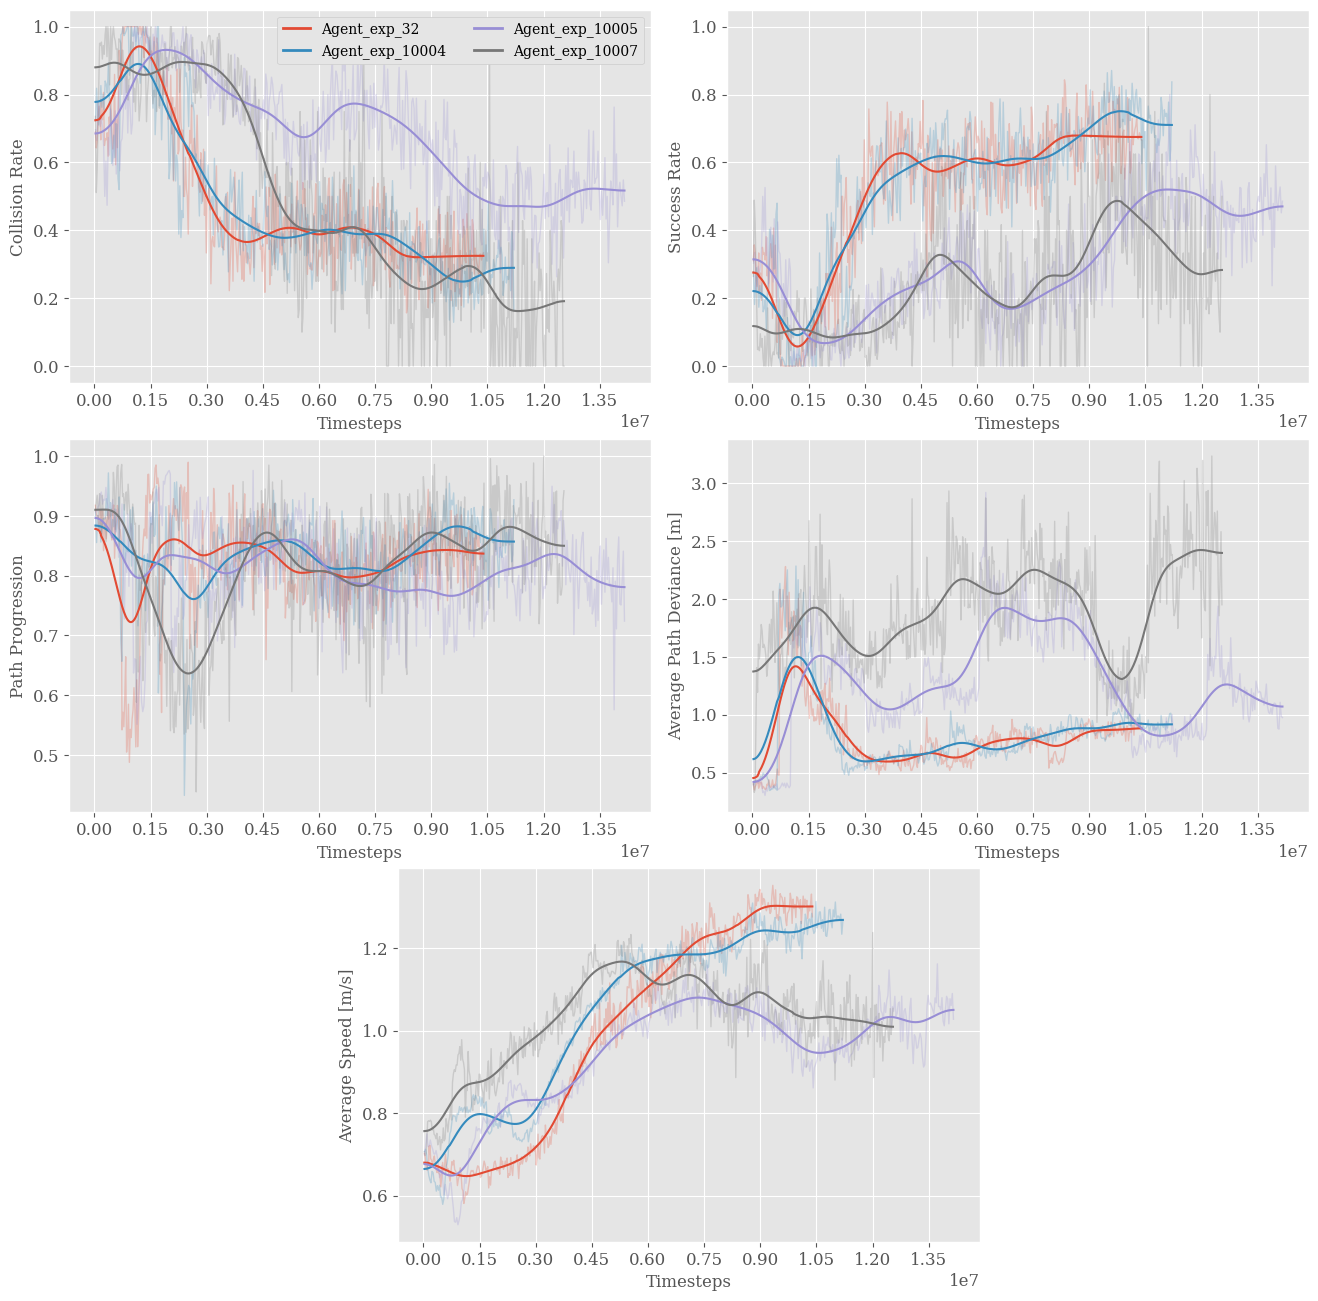

In [11]:
# Retrieve dataframes for the experiment
exp_id_to_dfs_ = {exp_id: exp_id_to_dfs[exp_id] for exp_id in exp_ids_multi}

#fig, ax = plt.subplots(n_metrics, 1, figsize=(10, 20))

fig, ax = centered_subplots([2, 2, 1], figsize=(16, 16))

for i, (exp_id, dfs) in enumerate(exp_id_to_dfs_.items()):
    for j, (metric_name, data) in enumerate(dfs.items()):

        # Plot values
        ax[j].plot(data["timestep"], data[metric_name], zorder=4, linewidth=1, color=current_cycler[i], alpha = 0.25, label=exp_agents[exp_id])
        
        # Plot trend
        values_smooth = gaussian_filter1d(data[metric_name], sigma=15)
        ax[j].plot(data["timestep"], values_smooth, zorder=5, linewidth=1.5 , alpha=1, linestyle="-", color=current_cycler[i])


        ax[j].set_xlabel("Timesteps")
        ax[j].set_ylabel(metrics_plotting_names[j])

        # Increase number of ticks on x-axis to make it more readable
        ax[j].xaxis.set_major_locator(plt.MaxNLocator(11))

        # If first plot add top right legend describing the colors
        legend_elements = [Line2D([0], [0], color=c, lw=2.0, label=label) for c, label in zip(current_cycler[:len(agent_names)], agent_names)]
        if j == 0:
            ax[j].legend(handles=legend_elements, loc="upper right", fontsize=10, framealpha=1.0, fancybox=True, ncol=2, alignment='center')

plt.subplots_adjust(wspace=0.3, hspace=0.15)

path = f"{base_path}multiplot_training_trajs.pdf"
plt.savefig(path, bbox_inches='tight')

##### Plot two agents

In [12]:
# The two experiment ids to compare agents from
exp_ids_double = [32, 10007]

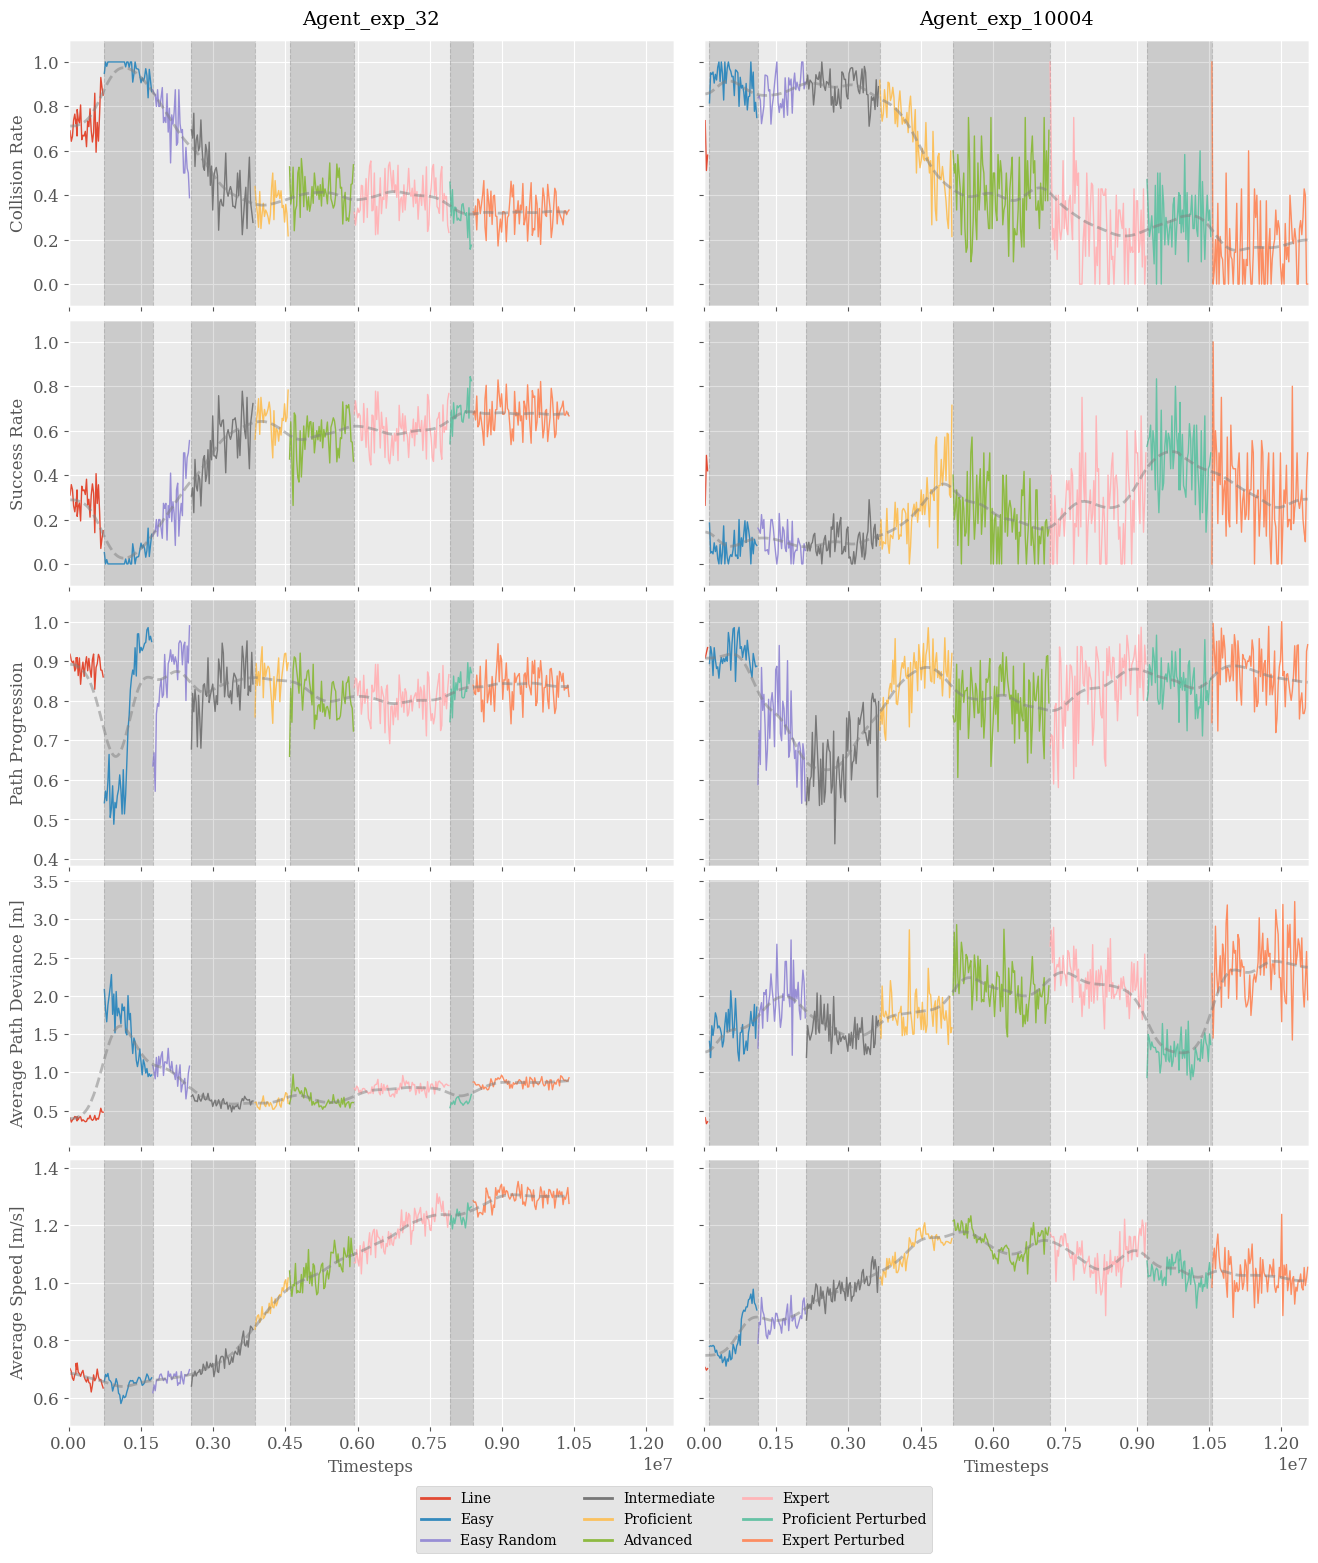

In [16]:
exp_id_to_dfs_ = {exp_id: exp_id_to_dfs[exp_id] for exp_id in exp_ids_double}

fig, ax = plt.subplots(n_metrics, 2, figsize=(16, 18), sharey="row")#, sharex="col")


# We force the x axes to be equal number of timesteps so that the plots are comparable
max_timesteps = 0
for i, (exp_id, dfs) in enumerate(exp_id_to_dfs_.items()):
    max_timesteps = max(max([data["timestep"].iloc[-1] for data in dfs.values()]), max_timesteps)

# Find min and max values for each metric to set the y-axis limits
min_per_metric = {metric_name: None for metric_name in dfs.keys()}
max_per_metric = {metric_name: None for metric_name in dfs.keys()}
for dfs in exp_id_to_dfs_.values():
    for metric_name, data in dfs.items():
        min_per_metric[metric_name] = min(min(data[metric_name]), min_per_metric[metric_name]) if min_per_metric[metric_name] else min(data[metric_name])
        max_per_metric[metric_name] = max(max(data[metric_name]), max_per_metric[metric_name]) if max_per_metric[metric_name] else max(data[metric_name])

# Pad min and maxs foreach metric by 10% of the range
padding = 0.1 # in percentage
for metric_name in min_per_metric.keys():
    diff = max_per_metric[metric_name] - min_per_metric[metric_name]
    min_per_metric[metric_name] -= padding * abs(diff)
    max_per_metric[metric_name] += padding * abs(diff)


for i, (exp_id, dfs) in enumerate(exp_id_to_dfs_.items()):
    ax[0, i].set_title(agent_names[i], fontsize=14, y=1.03)

    for j, (metric_name, data) in enumerate(dfs.items()):
        # Group data by scenario and plot each scenario with different color
        for k, scenario in enumerate(scenarios):
            scenario_data = data[data["scenario"] == scenario]
            ax[j, i].plot(scenario_data["timestep"], scenario_data[metric_name], zorder=5, linewidth=1, color=current_cycler[k])
        
        # Plot trend
        values_smooth = gaussian_filter1d(data[metric_name], sigma=10)
        ax[j, i].plot(data["timestep"], values_smooth, zorder=5, linewidth=2.0, color="gray", alpha=0.5, linestyle="--")

        ylow_fill, yhigh_fill = min_per_metric[metric_name], max_per_metric[metric_name] #ax[j, i].get_ybound()

        for k, scenario in enumerate(scenarios):
            scenario_data = data[data["scenario"] == scenario]
            next_scenario_data = data[data["scenario"] == scenarios[k + 1]] if k + 1 < len(scenarios) else None
            last_index_for_fill = max_timesteps if next_scenario_data is None else next_scenario_data["timestep"].iloc[0]
            color = "white" if k % 2 == 0 else "gray"
            ax[j, i].fill_between([scenario_data["timestep"].iloc[0], last_index_for_fill], ylow_fill, yhigh_fill, color=color, alpha=0.25, zorder=1)
        
        ax[j, i].set_xlabel("Timesteps") if j == n_metrics - 1 else ax[j, i].set_xlabel("")
        if j < n_metrics - 1:
            ax[j, i].set_xticklabels([])
        if i == 0:
            ax[j, i].set_ylabel(metrics_plotting_names[j])
        ax[j, i].set_xlim(0, max_timesteps + data["timestep"].iloc[0])
        ax[j, i].set_ylim(ylow_fill, yhigh_fill)

        # Add upper axis with scenario names if first plot and only ticks else
        scenario_text_positions_x = []
        upper_ax_ticks = []
        for scenario in scenarios:
            scenario_data = data[data["scenario"] == scenario]
            midpoint = (scenario_data["timestep"].iloc[0] + scenario_data["timestep"].iloc[-1]) // 2
            scenario_text_positions_x.append(midpoint)
            upper_ax_ticks.append(scenario_data["timestep"].iloc[0])

        upper_ax_ticks = upper_ax_ticks[1:]  # Remove first tick
        ax_upper = ax[j, i].twiny()
        ax_upper.set_xlim(0, max_timesteps)
        ax_upper.set_xticks(upper_ax_ticks)
        ax_upper.tick_params(direction='in', length=0, width=0, colors='w') # Hide ticks
        ax_upper.grid(True, which='both', linestyle='--', linewidth=0.8, color='gray', alpha=0.3, zorder=2)
        ax_upper.set_xticklabels([' ' for _ in range(len(scenarios) - 1)])

        # Align axes
        ax_upper.set_xbound(ax[j, i].get_xbound())

        # Increase number of ticks on x-axis to make it more readable
        ax[j, i].xaxis.set_major_locator(plt.MaxNLocator(11))

        # If final plot add label below x axis describing the colors
        legend_elements = [Line2D([0], [0], color=c, lw=2.0, label=label) for c, label in zip(current_cycler[:len(scenarios)], scenarios_plotting_names)]
        if j == n_metrics - 1 and i == 0:
            ax[j, i].legend(handles=legend_elements, loc="upper center", bbox_to_anchor = (1,-0.2,0,0), fontsize=10, framealpha=1.0, fancybox=True, ncol=3, alignment='center')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.05, hspace=0.05)

path = f"{base_path}exp_{exp_ids_double[0]}_vs_{exp_ids_double[1]}_training_trajs.pdf"
plt.savefig(path, bbox_inches='tight')